## Preprocessing and Latent Embedding Computation

In [1]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)


# Load data
data_path = '/home/lexent/ensemble-ti/ensemble-ti/data/eb/eb_counts.pkl'
df = pd.read_pickle(data_path)

In [6]:
%cd /home/lexent/ensemble-ti/ensemble-ti/

/home/lexent/ensemble-ti/ensemble-ti


In [2]:
import scipy

ad = sc.AnnData(df)

In [ ]:
sc.pp.highly_variable_genes(ad, n_top_genes=2000, flavor='cell_ranger')

In [3]:
if isinstance(ad.X, scipy.sparse.csr_matrix):
    ad.X = ad.X.todense()

ad.var_names = [v.split(' ')[0] for v in ad.var_names]

In [4]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, va, n_comps = run_pca(ad, use_hvg=False, n_components=100)

ModuleNotFoundError: No module named 'utils'

In [10]:
np.sum(va)

0.17015506

In [11]:
ad.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Components computed: 100


In [12]:
import magic

magic_op = magic.MAGIC(random_state=0, solver='approximate')
X_magic = magic_op.fit_transform(ad.X, genes='all_genes')
ad.obsm['X_magic'] = X_magic

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17845 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 25.71 seconds.
    Calculating KNN search...
    Calculated KNN search in 36.40 seconds.
    Calculating affinities...
    Calculated affinities in 36.35 seconds.
  Calculated graph and diffusion operator in 98.51 seconds.
  Calculating imputation...
  Calculated imputation in 0.15 seconds.
Calculated MAGIC in 102.35 seconds.


## Embedding computation

In [13]:
import warnings
from train_metric import train_metric_learner

# preprocessed_data.obsm['X'] = preprocessed_data.X
with warnings.catch_warnings():
    # Filter out user warnings from PyTorch about saving scheduler state
    warnings.simplefilter("ignore")
    train_metric_learner(ad, n_episodes=5, n_metric_epochs=30, obsm_data_key='X_pca', code_size=10,
        backend='leiden', device='cuda', save_path='/content/metric',
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 10},
        # trainer_kwargs={'batch_size': 32, 'lr_scheduler': 'cosine', 'lr_scheduler_kwargs' : {'t0': 2, 'tmul': 2}}
        trainer_kwargs={'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 256}
    )

Generating initial clusters
Runtime for determine_cell_clusters(): 42.945880651474


  0%|          | 0/30 [00:00<?, ?it/s]

Training for episode: 1


100%|██████████| 16821/16821 [00:11<00:00, 1492.73it/s]


Re-generating clusters for episode: 1


  0%|          | 0/30 [00:00<?, ?it/s]

Runtime for determine_cell_clusters(): 3.0425662994384766
Time Elapsed for epoch: 588.0291211605072s
Training for episode: 2


100%|██████████| 16821/16821 [00:10<00:00, 1581.44it/s]


Re-generating clusters for episode: 2


  0%|          | 0/30 [00:00<?, ?it/s]

Runtime for determine_cell_clusters(): 3.6109812259674072
Time Elapsed for epoch: 590.1318998336792s
Training for episode: 3


100%|██████████| 16821/16821 [00:10<00:00, 1554.90it/s]


Re-generating clusters for episode: 3


  0%|          | 0/30 [00:00<?, ?it/s]

Runtime for determine_cell_clusters(): 2.8246712684631348
Time Elapsed for epoch: 595.4596748352051s
Training for episode: 4


100%|██████████| 16821/16821 [00:10<00:00, 1579.22it/s]


Re-generating clusters for episode: 4


  0%|          | 0/30 [00:00<?, ?it/s]

Runtime for determine_cell_clusters(): 2.7636046409606934
Time Elapsed for epoch: 603.408613204956s
Training for episode: 5


100%|██████████| 16821/16821 [00:11<00:00, 1510.79it/s]


Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 2.208745241165161
Time Elapsed for epoch: 600.558694601059s
Runtime for train_metric_learner(): 3029.2898778915405


# DE analysis

In [ ]:
ad_de = sc.AnnData(preprocessed_data.obsm['X_magic'])
# ad_de.obsm['X_pca'] = preprocessed_data.obsm['X_pca']
ad_de.obs_names = preprocessed_data.obs_names
ad_de.var_names = preprocessed_data.var_names
ad_de.obs['clusters'] = preprocessed_data.obs['metric_clusters'].astype('category')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


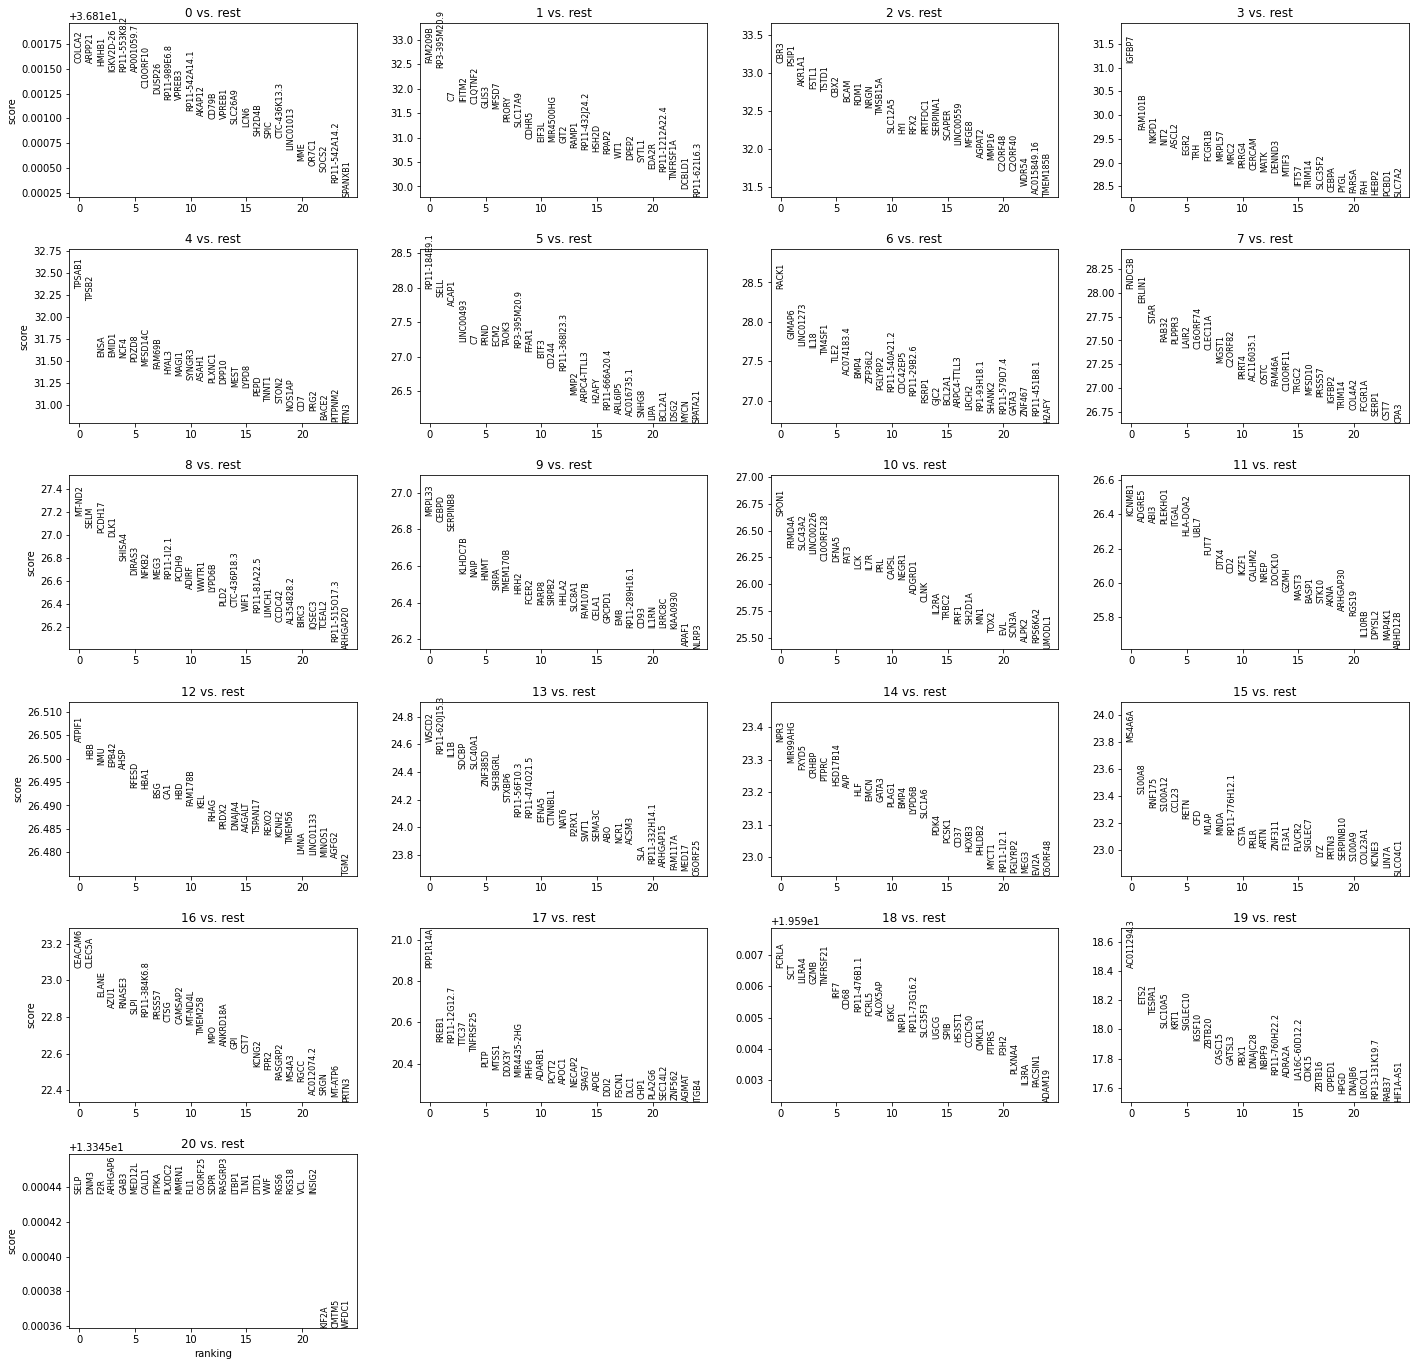

In [ ]:
sc.tl.rank_genes_groups(ad_de, 'clusters', method='wilcoxon', key_added = "w-test")
sc.pl.rank_genes_groups(ad_de, n_genes=25, sharey=False, key = "w-test")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


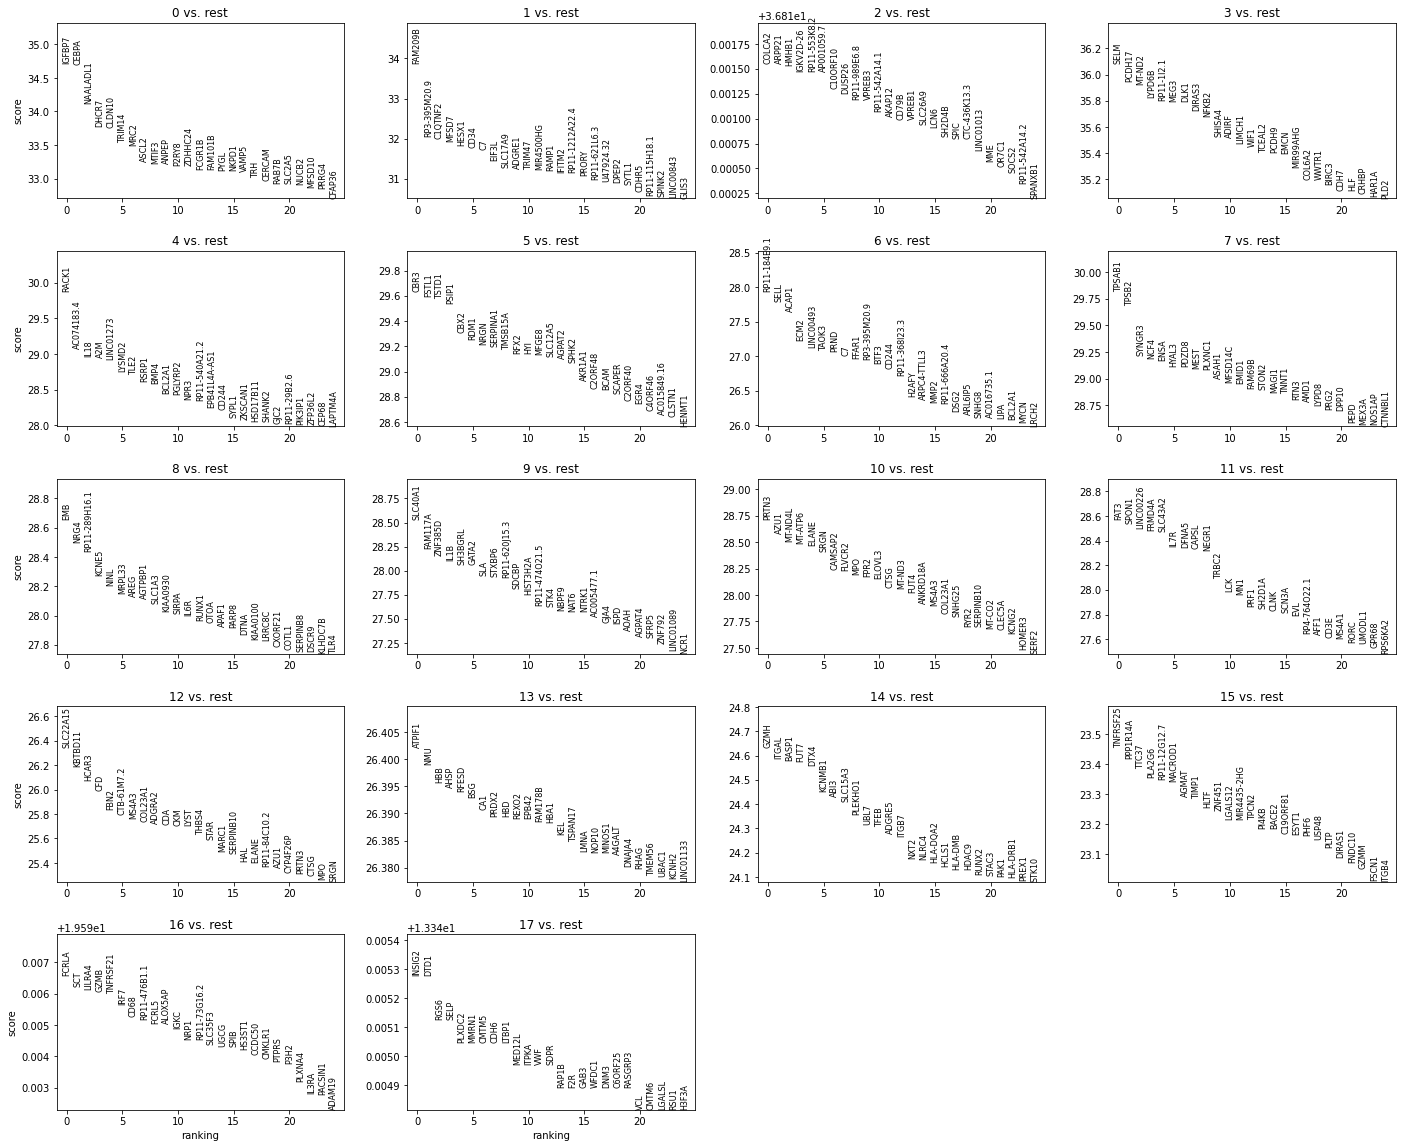

In [ ]:
sc.tl.rank_genes_groups(ad_de, 'clusters', method='wilcoxon', key_added = "w-test")
sc.pl.rank_genes_groups(ad_de, n_genes=25, sharey=False, key = "w-test")

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2, etc.


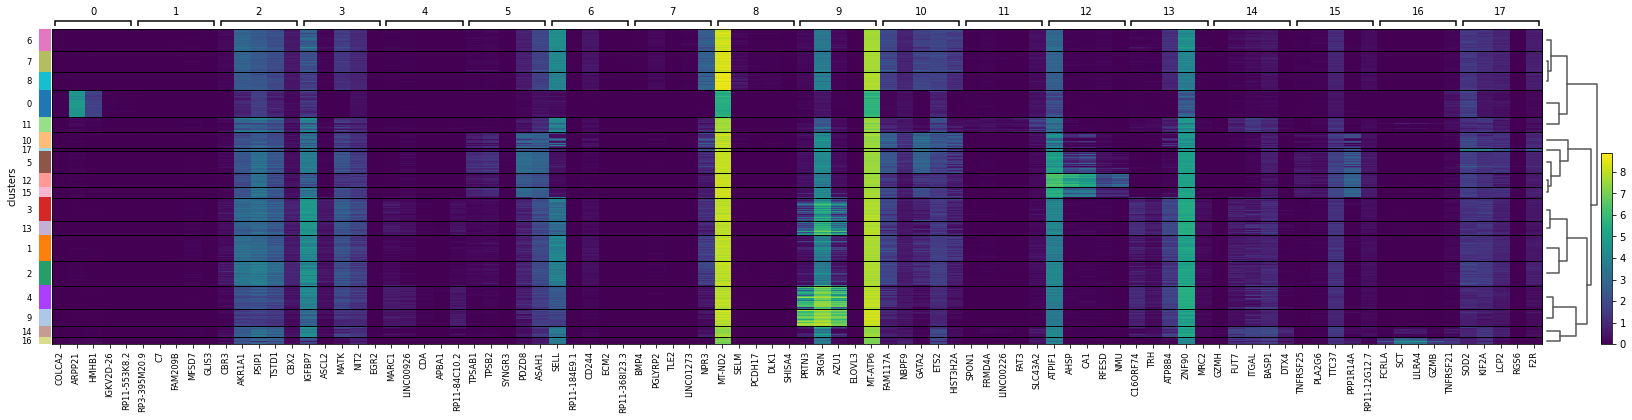

In [ ]:
sc.pl.rank_genes_groups_heatmap(ad_de, n_genes=5, key="w-test", groupby="clusters", show_gene_labels=True)
# sc.pl.rank_genes_groups_dotplot(ad_de, n_genes=5, key="w-test", groupby="clusters")

# Plotting and Visualization

In [14]:
%matplotlib inline

In [15]:
from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters
import matplotlib.pyplot as plt

In [16]:
X_embedded = generate_plot_embeddings(ad.obsm['metric_embedding'], method='umap', random_state=0)
ad.obsm['X_met_embedding'] = X_embedded

Runtime for generate_plot_embeddings(): 22.068524599075317


In [17]:
samples = pd.read_csv('/content/drive/MyDrive/genomics/embryoid_body_phate/eb_sample_labels.csv')
samples_ = [int(s.split('-')[-1]) for s in samples['sample_labels']]

### Timepoint information in EB dataset

The following embedding shows timepoint of cells in the Embryoid body dataset used in the PHATE paper. As can be seen in the embedding the cells in the dataset can be split into 5 timepoints. Hence, our method is able to preserve timepoint information of cells.

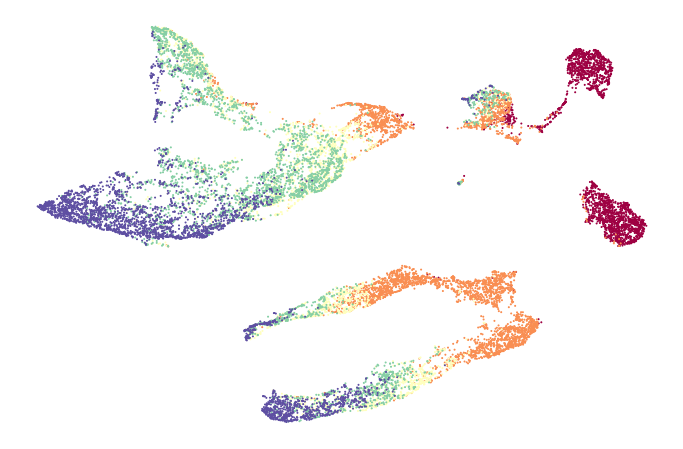

In [18]:
plot_embeddings(X_embedded, s=1, c=samples_, cmap='Spectral', figsize=(12, 8))

### Expression of cell cycle genes

The early expression of CCNE1 denotes S phase of ESC cells. G1 phase specific markers like CDKN1A/B/C are expressed in later stages of the dataset cells as cells with lesser differentiation potential have longer G1 phase. Obviously, the expression of these G1 specific markers will be less in early cells due to rapid cell cycle. This trend is captured by the below plot.

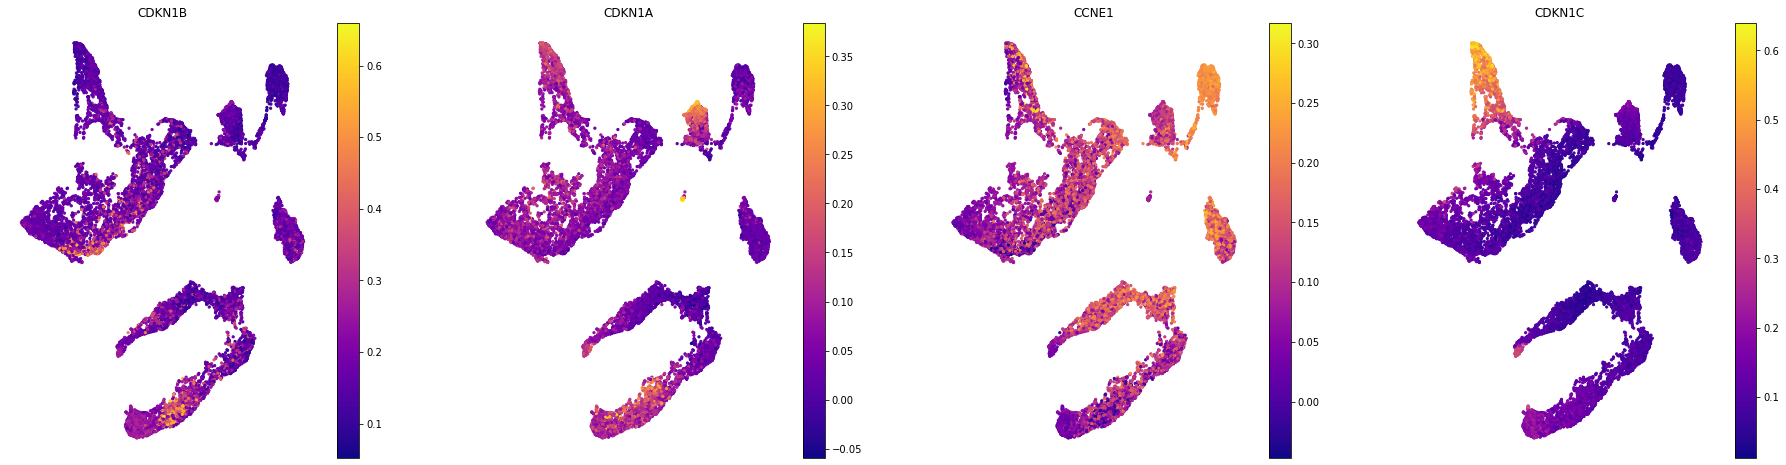

In [26]:
plot_gene_expression(ad, genes=['CCNE1', 'CDKN1A', 'CDKN1B', 'CDKN1C'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Identification of major lineages

### ESCs
The plot below shows some canonical marker genes for ESC's which are upregulated during the starting phase but as differentiation proceeds there activity is downregulated.

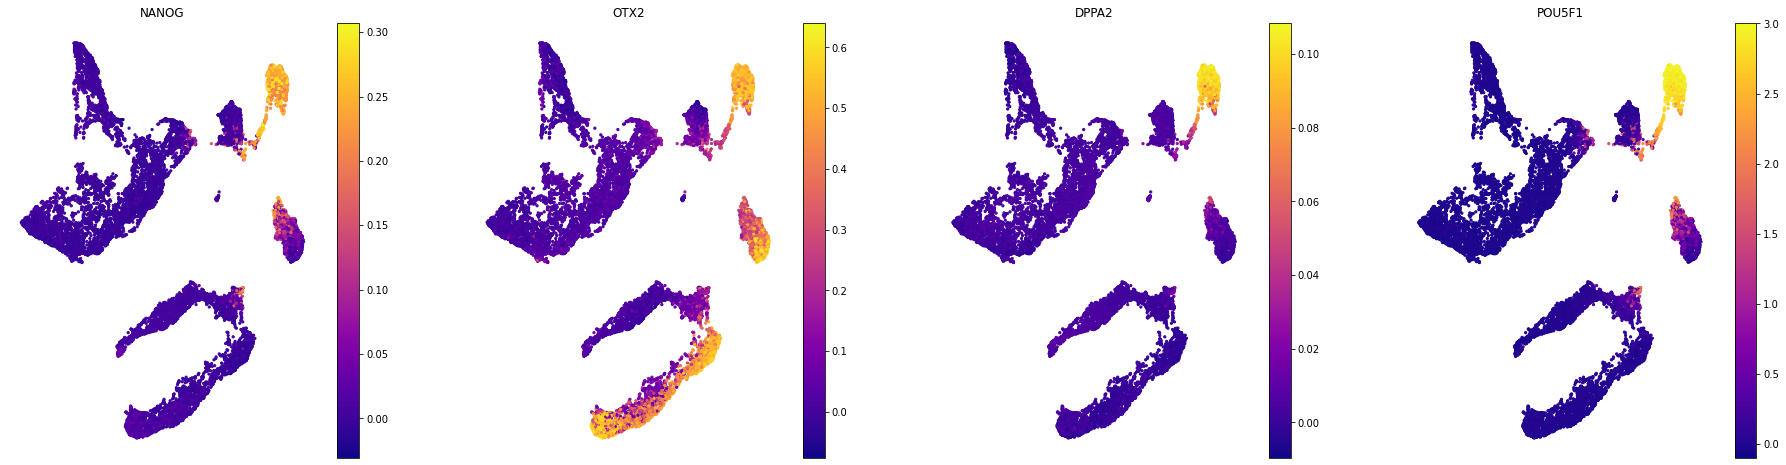

In [27]:
plot_gene_expression(ad, genes=['POU5F1', 'NANOG', 'DPPA2', 'OTX2'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Canonical markers for the Primitive Streak (PS) lineage

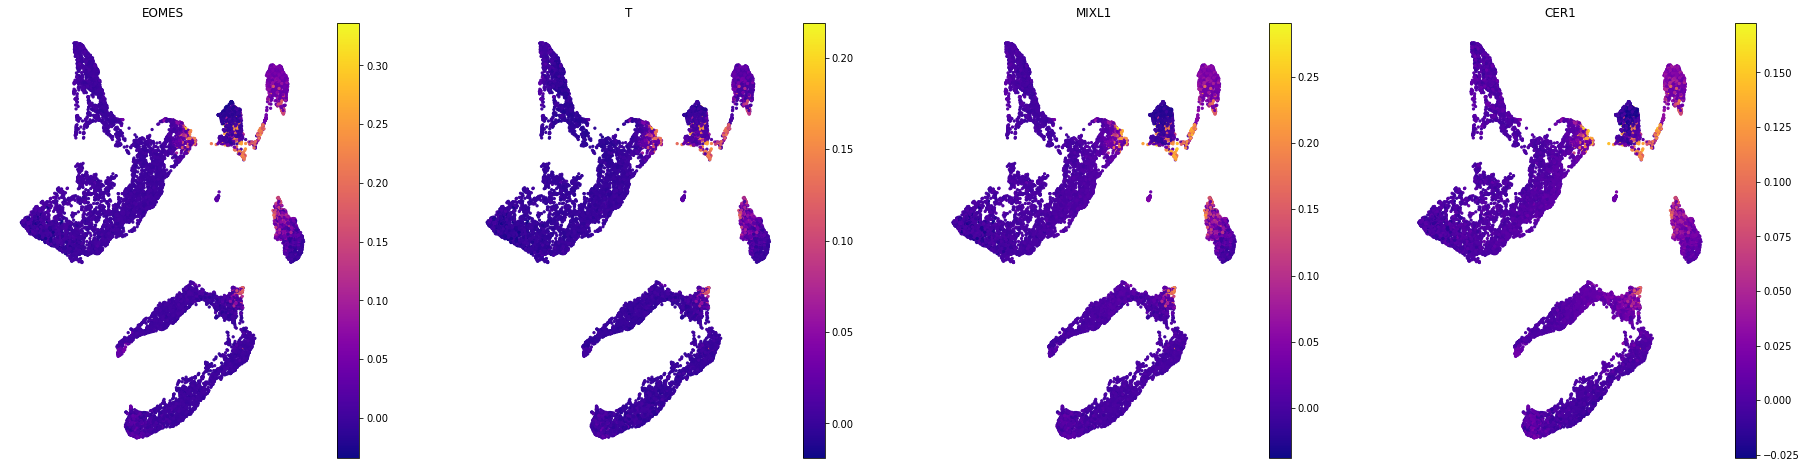

In [20]:
plot_gene_expression(ad, genes=['EOMES', 'MIXL1', 'CER1', 'T'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Canonical markers for the NeuroEctoderm lineage (NE)

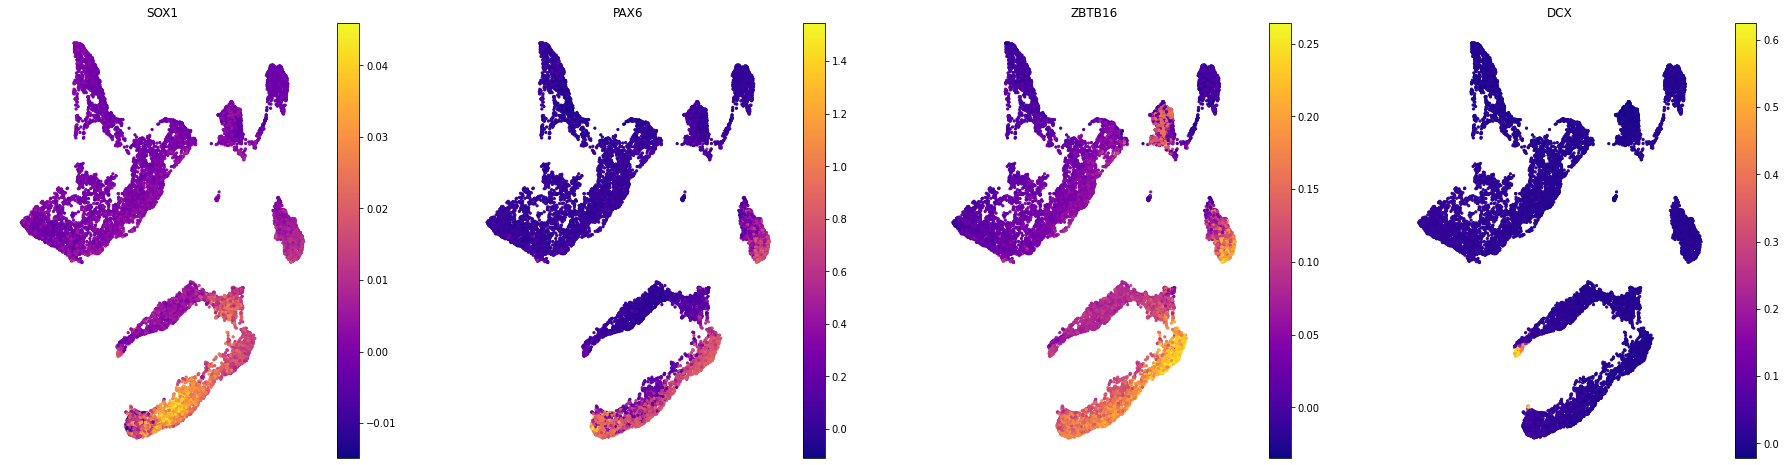

In [42]:
plot_gene_expression(ad, genes=['PAX6', 'ZBTB16', 'SOX1', 'SOX2'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Canonical markers for the Neural Crest (NC) lineage

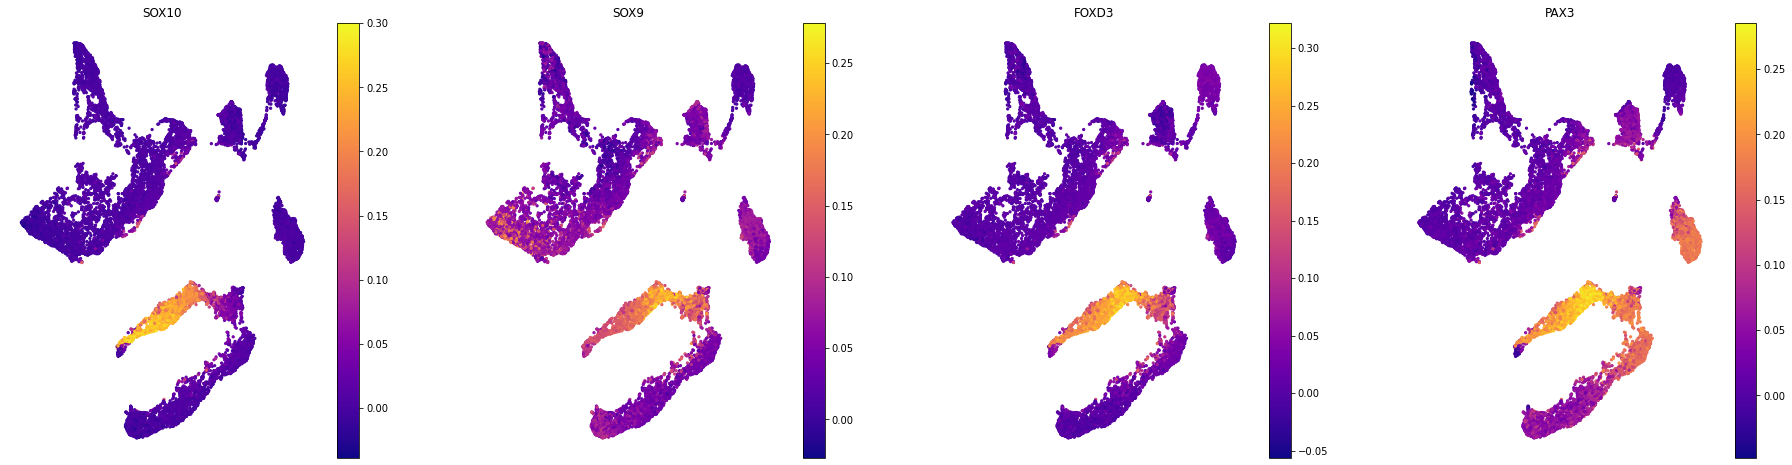

In [43]:
plot_gene_expression(ad, genes=['PAX3', 'FOXD3', 'SOX9', 'SOX10'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Canonical markers for the Endoderm (EN) lineage

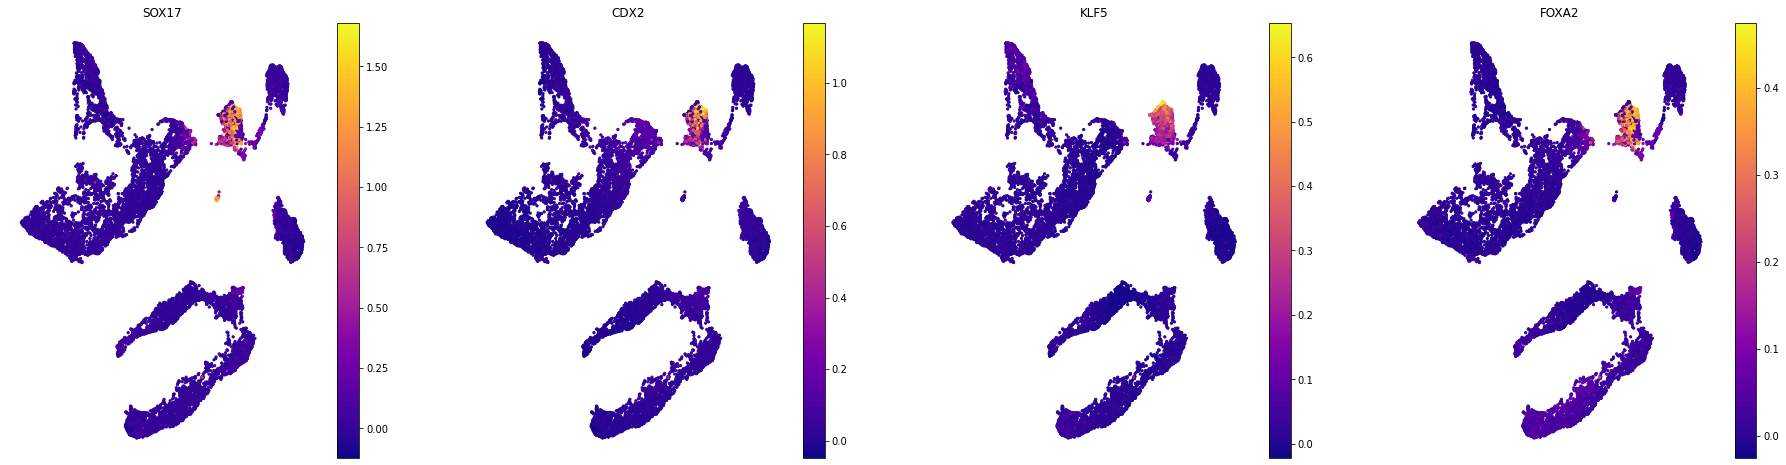

In [44]:
plot_gene_expression(ad, genes=['FOXA2', 'SOX17', 'CDX2', 'KLF5'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

### Canonical markers for the Mesoderm (ME) lineage

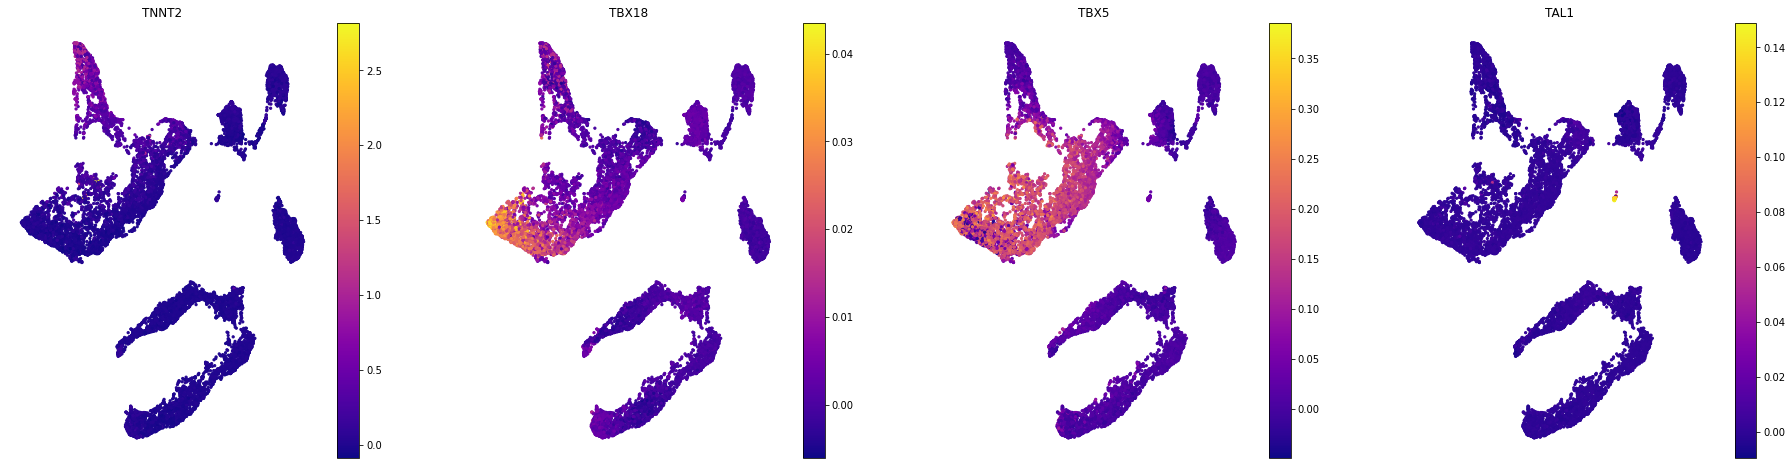

In [46]:
plot_gene_expression(ad, genes=['TBX18', 'TAL1', 'TBX5', 'TNNT2'], figsize=(32, 8), cmap='plasma', obsm_key='X_met_embedding')

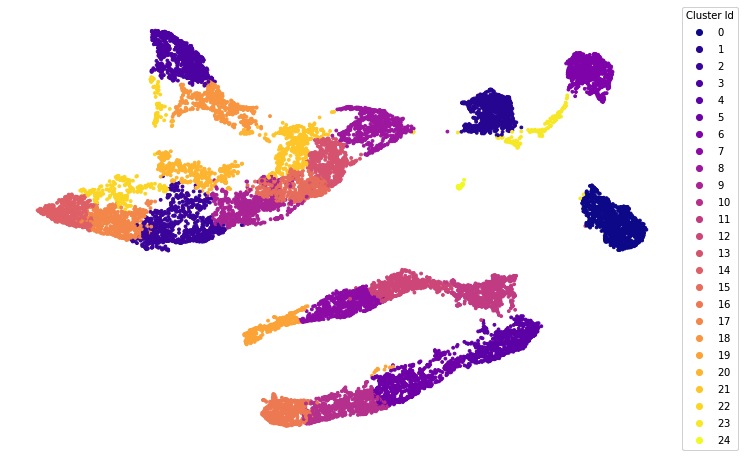

In [25]:
plot_clusters(ad, cluster_key='metric_clusters', embedding_key='X_met_embedding', cmap='plasma')

In [ ]:
X_embedded_pca = generate_plot_embeddings(ad.obsm['X_pca'], method='umap', random_state=random_seed)
ad.obsm['X_pca_embedding'] = X_embedded_pca

Runtime for generate_plot_embeddings(): 34.20930504798889


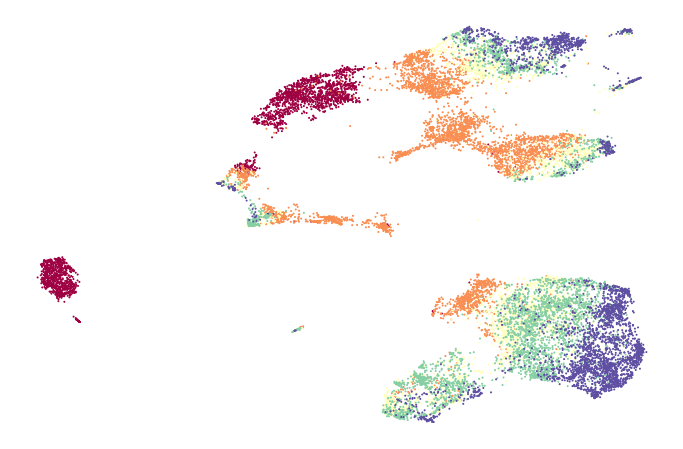

In [ ]:
plot_embeddings(X_embedded_pca, s=1, c=samples_, cmap='Spectral', figsize=(12, 8))

In [ ]:
plot_gene_expression(preprocessed_data, genes=['ITGA2B', 'IRF8', 'MPO', 'MPP2', 'CD34', 'CD79B', 'GATA1'], figsize=(32, 8), cmap='plasma', obsm_key='X_pca_embedding')

In [ ]:
from utils.util import determine_cell_clusters

determine_cell_clusters(preprocessed_data, obsm_key='X_pca', backend='leiden', cluster_key='pca_clusters', random_state=0, resolution=0.8)
plot_clusters(preprocessed_data, cluster_key='pca_clusters', embedding_key='X_pca_embedding', cmap='plasma')

# Trajectory Visualization

In [28]:
import numpy as np

communities = ad.obs['metric_clusters'].to_numpy().astype(np.int)

In [ ]:
from sklearn.neighbors import NearestNeighbors

X = ad.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [29]:
adj_conn = ad.obsp['connectivities']
adj_dist = ad.obsp['distances']

In [30]:
from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity

In [37]:
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, threshold=2.5)

Runtime for compute_undirected_cluster_connectivity(): 1.0933430194854736


In [ ]:
from utils.util import get_start_cell_cluster_id

start_cell_ids = adata.obs['palantir_pseudotime'].idxmin()
print(start_cell_ids)
start_cell_ids = [start_cell_ids] if isinstance(start_cell_ids, str) else list(start_cell_ids)
start_cluster_ids = get_start_cell_cluster_id(preprocessed_data, start_cell_ids, communities)
print(start_cluster_ids)

In [39]:
from utils.plot import plot_connectivity_graph, plot_trajectory_graph

Runtime for compute_connectivity_graph(): 0.020032167434692383


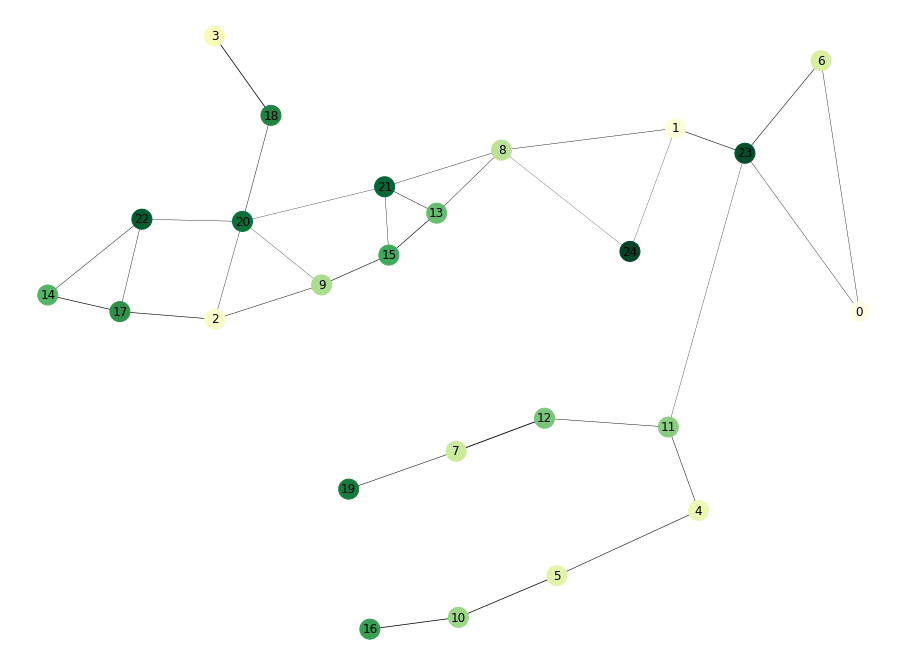

In [40]:
plot_connectivity_graph(ad.obsm['X_met_embedding'], communities, un_connectivity, mode='undirected')

In [ ]:
connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=1.5)

Runtime for compute_directed_cluster_connectivity(): 0.0821690559387207


Runtime for compute_trajectory_graph(): 0.00611567497253418


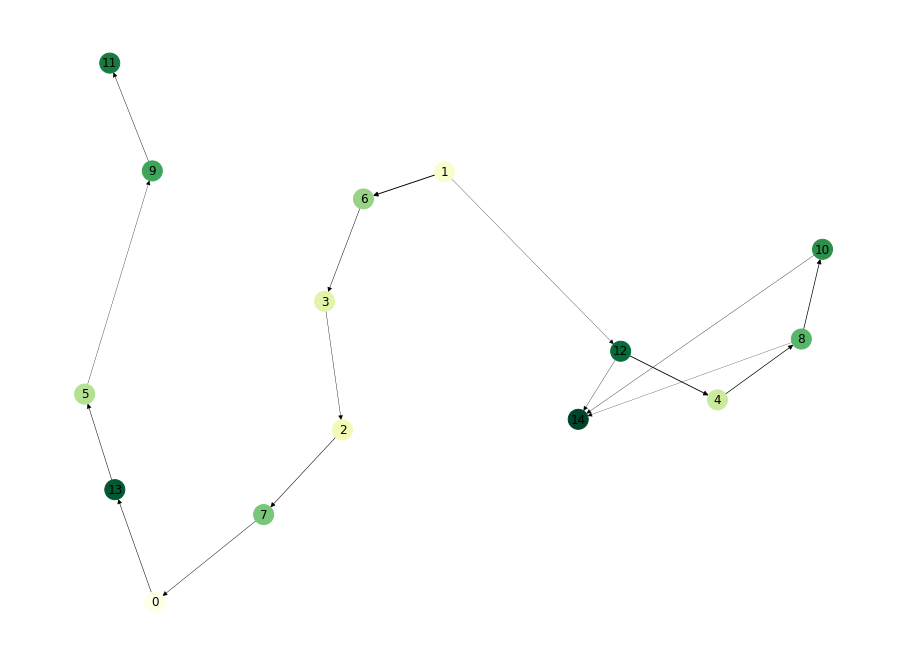

In [ ]:
plot_trajectory_graph(preprocessed_data.obsm['X_met_embedding'], communities, connectivity, start_cluster_ids)

# Pseudotime Computation

In [ ]:
from models.ti.graph import compute_trajectory_graph

G, _ = compute_trajectory_graph(preprocessed_data.obsm['X_met_embedding'], preprocessed_data.obs['metric_clusters'], connectivity, start_cluster_ids)

Runtime for compute_trajectory_graph(): 0.009695768356323242


In [ ]:
import networkx as nx

connectivity_G = nx.to_numpy_array(G)

In [ ]:
from models.ti.pseudotime import compute_pseudotime

start_cell_ids = adata.obs['palantir_pseudotime'].idxmin()
start_cell_ids = [start_cell_ids] if isinstance(start_cell_ids, str) else list(start_cell_ids)
print(start_cell_ids)

pseudotime = compute_pseudotime(
    preprocessed_data, start_cell_ids, adj_conn, adj_dist, connectivity_G, comm_key='metric_clusters', data_key='metric_embedding'
)

['Run5_205922701598003']
Runtime for compute_pseudotime(): 1.2719049453735352


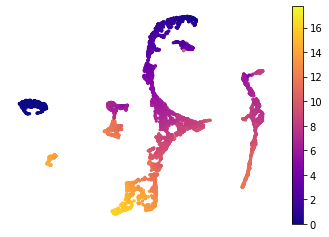

In [ ]:
from utils.plot import plot_pseudotime

plot_pseudotime(preprocessed_data, embedding_key='X_met_embedding', pseudotime_key='metric_pseudotime', cmap='plasma')

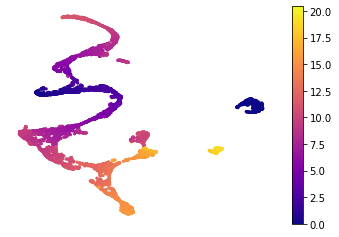

In [ ]:
from utils.plot import plot_pseudotime

plot_pseudotime(preprocessed_data, embedding_key='X_met_embedding', pseudotime_key='metric_pseudotime', cmap='plasma')

In [ ]:
# from models.ti.downstream import get_terminal_states, compute_cluster_lineage_likelihoods, compute_cell_branch_probs

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss

from utils.util import get_start_cell_cluster_id


def get_terminal_states(ad, start_cell_ids, use_rep='metric_embedding', cluster_key='metric_clusters', graph_key='metric_trajectory'):
    # Check 1: Input must be in AnnData format
    assert isinstance(ad, sc.AnnData)
 
    # Check 2: All keys must be present
    if use_rep not in ad.obsm_keys():
        raise ValueError(f'Representation `{use_rep}` not present in ad.obsm.')
    if cluster_key not in ad.obs_keys():
        raise ValueError(f'Cluster key `{cluster_key}` not present in ad.obs.')
    if graph_key not in ad.uns_keys():
        raise ValueError(f'Graph Key `{graph_key}` not present in ad.uns.')

    communities = ad.obs[cluster_key]
    X = pd.DataFrame(ad.obsm[use_rep], index=communities.index)
    g = ad.uns[graph_key]
    start_cluster_ids = set(get_start_cell_cluster_id(ad, start_cell_ids, communities))

    # Find clusters with no outgoing edges
    adj_g = nx.convert_matrix.to_numpy_array(g)
    nodes_g = np.array(nx.nodes(g))
    terminal_candidates_1 = set(nodes_g[np.sum(adj_g, axis=1) == 0])

    # Find clusters with maximal embedding components (as done in Palantir)
    max_ids = X.idxmax(axis=0)
    terminal_candidates_2 = set(communities.loc[max_ids])
    
    # Compute betweeness of second set of candidates and exclude
    # clusters with low betweenness (based on MAD)
    betweenness = nx.betweenness_centrality(g)
    mad_betweenness = ss.median_absolute_deviation(list(betweenness.values()))
    median_betweenness = np.median(list(betweenness.values()))
    threshold = median_betweenness - 3 * mad_betweenness
    threshold = threshold if threshold > 0 else 0

    terminal_candidates_2 = set(c for c in terminal_candidates_2 if betweenness[c] < threshold)
    terminal_candidates = terminal_candidates_1.union(terminal_candidates_2)

    # Remove starting clusters
    terminal_candidates = terminal_candidates - start_cluster_ids
    
    # Remove clusters with no incoming edges which are not start_clusters
    islands = set(nodes_g[np.sum(adj_g, axis=0) == 0]) - start_cluster_ids
    terminal_candidates = terminal_candidates - islands

    ad.uns['metric_terminal_clusters'] = terminal_candidates
    return terminal_candidates


def compute_cluster_lineage_likelihoods(ad, cluster_key='metric_clusters', terminal_key='metric_terminal_clusters', graph_key='metric_trajectory'):
    communities = ad.obs[cluster_key]
    cluster_ids = np.unique(communities)
    terminal_ids = ad.uns[terminal_key]
    g = ad.uns[graph_key]

    adj_g = nx.convert_matrix.to_numpy_array(g)
    nz_inds = adj_g.sum(axis=1) > 0
    adj_g[nz_inds] = adj_g[nz_inds] / adj_g[nz_inds].sum(axis=1)[:, np.newaxis]

    cluster_lineage_likelihoods = pd.DataFrame(np.zeros((len(cluster_ids), len(terminal_ids))), columns=terminal_ids, index=cluster_ids)
    for t_id in terminal_ids:
        for c_id in cluster_ids:
            # All terminal states end up in that state
            if c_id == t_id:
                cluster_lineage_likelihoods.loc[c_id, t_id] = 1.0
                continue

            # Compute total likelihood along all possible paths
            paths = nx.all_simple_paths(g, c_id, t_id)
            likelihood = 0
            for path in paths:
                next_state = path[0]
                _l = 1
                for idx in range(1, len(path)):
                    _l *= adj_g[next_state, path[idx]]
                    next_state = path[idx]
                likelihood += _l
            cluster_lineage_likelihoods.loc[c_id, t_id] = likelihood

    # Row-Normalize the lineage likelihoods
    nz_inds = cluster_lineage_likelihoods.sum(axis=1) > 0
    cluster_lineage_likelihoods[nz_inds] = cluster_lineage_likelihoods[nz_inds].div(cluster_lineage_likelihoods[nz_inds].sum(axis=1), axis=0)

    return cluster_lineage_likelihoods


def compute_cell_branch_probs(ad, adj_dist, cluster_lineages, cluster_key='metric_clusters', graph_key='metric_trajectory'):
    communities = ad.obs[cluster_key]
    cluster_ids = np.unique(communities)
    n_clusters = len(cluster_ids)
    N = communities.shape[0]

    # Prune the distance graph
    g = ad.uns[graph_key]
    adj_g = nx.convert_matrix.to_numpy_array(g)
    adj_dist_pruned = _prune_network_edges(communities, adj_dist, adj_g)
    adj_dist_pruned = pd.DataFrame(adj_dist_pruned, index=communities.index, columns=communities.index)

    # Compute the cell to cluster connectivity
    cell_branch_probs = pd.DataFrame(np.zeros((N, n_clusters)), index=communities.index, columns=cluster_ids)
    for idx in communities.index:
        row = adj_dist_pruned.loc[idx, :]
        neighboring_clus = communities[np.where(row > 0)[0]]

        for clus_i in set(neighboring_clus):
            num_clus_i = np.sum(row.loc[neighboring_clus.index[np.where(neighboring_clus == clus_i)[0]]])
            w_i = num_clus_i / np.sum(row)
            cell_branch_probs.loc[idx, clus_i] = w_i

    # Project onto cluster lineage probabilities
    cell_branch_probs = cell_branch_probs.dot(cluster_lineages)
    return cell_branch_probs


def _prune_network_edges(communities, adj_sc, adj_cluster):
    n_communities = np.unique(communities).shape[0]
    n_pruned = 0

    # Create cluster index
    clusters = []
    for idx in range(n_communities):
        cluster_idx = communities == idx
        clusters.append(cluster_idx)

    n_row, n_col = adj_cluster.shape
    col_ids = np.arange(n_col)
    for c_idx in range(n_row):
        cluster_i = clusters[c_idx]
        non_connected_clusters = col_ids[adj_cluster[c_idx] == 0]
        for nc_idx in non_connected_clusters:
            if nc_idx == c_idx:
                continue
            cluster_nc = clusters[nc_idx]
            n_pruned += np.sum(adj_sc[cluster_i, :][:, cluster_nc] > 0)
            adj_sc[cluster_i, :][:, cluster_nc] = np.zeros_like(adj_sc[cluster_i, :][:, cluster_nc]).squeeze()

    print(f'Successfully pruned {n_pruned} edges')
    return adj_sc


In [ ]:
preprocessed_data.uns['metric_trajectory'] = G
start_cell_ids = adata.obs['palantir_pseudotime'].idxmin()
get_terminal_states(preprocessed_data, [start_cell_ids])

{10, 12, 16, 18, 20}

In [ ]:
cluster_lineages = compute_cluster_lineage_likelihoods(preprocessed_data)

In [ ]:
cell_branch_probs = compute_cell_branch_probs(preprocessed_data, adj_dist.todense(), cluster_lineages)

Successfully pruned 10073 edges


In [ ]:
cell_branch_probs = cell_branch_probs.div(cell_branch_probs.sum(axis=1), axis=0)

In [ ]:
import scipy.stats as ss

ent = np.sum(-cell_branch_probs * np.log(cell_branch_probs.astype(np.float)), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


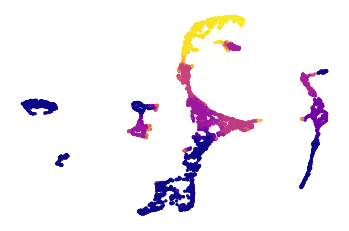

In [ ]:
plot_embeddings(X_embedded, s=5, c=ent, cmap='plasma')

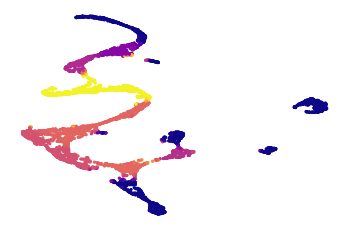

In [ ]:
plot_embeddings(X_embedded, s=5, c=ent, cmap='plasma')

7
12
13
15
16


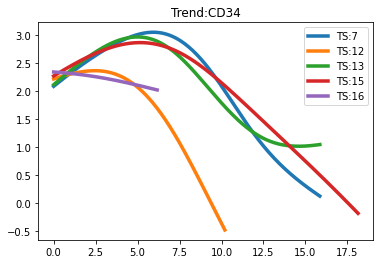

In [ ]:
import pygam as pg
import matplotlib.pyplot as plt

t_states = cell_branch_probs.columns
pt = preprocessed_data.obs['metric_pseudotime']
imputed_data_df = pd.DataFrame(preprocessed_data.obsm['X_magic'], columns=preprocessed_data.var_names, index=preprocessed_data.obs_names)
title_gene = 'CD34'
gene_exp = imputed_data_df.loc[:, title_gene]

for i in t_states:
    loc_i = np.where(cell_branch_probs.loc[:, i] > 0.7)[0]
    print(i)
    val_pt = pt[loc_i]
    max_val_pt = max(val_pt)

    loc_i_bp = np.where(cell_branch_probs.loc[:, i] > 0.000)[0]
    x = np.asarray(pt)[loc_i_bp].reshape(-1, 1)
    y = np.asarray(gene_exp)[loc_i_bp].reshape(-1, 1)
    weights = np.asarray(cell_branch_probs.loc[:, i])[loc_i_bp].reshape(-1, 1)

    geneGAM = pg.LinearGAM(n_splines=10, spline_order=4, lam=10).fit(x, y, weights=weights)
    nx_spacing = 100
    xval = np.linspace(0, max_val_pt, nx_spacing * 2)
    yg = geneGAM.predict(X=xval)

    plt.gca().plot(xval, yg, linewidth=3.5, zorder=3, label='TS:' + str(i))
plt.legend()
plt.title('Trend:' + title_gene)
plt.show()

In [ ]:
import numpy as np
import scanpy as sc
import torch

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)


# Load data
data_path = '/content/drive/MyDrive/genomics/human_hematopoesis_data/palantir/human_cd34_bm_rep1.h5ad'
adata = sc.read(data_path)

In [ ]:
import pandas as pd

raw_df = pd.DataFrame(data=adata.raw.X.todense(), index=adata.obs_names, columns=adata.var_names)
data = sc.AnnData(raw_df)

In [ ]:
import palantir
from utils.util import log_transform

sc.pp.normalize_per_cell(data)
log_transform(data, pseudo_count=0.1)
sc.pp.highly_variable_genes(data, n_top_genes=1500, flavor='cell_ranger')
pca_projections, _ = palantir.utils.run_pca(data, use_hvg=False)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)

In [ ]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)
start_cell = adata.obs['palantir_pseudotime'].idxmin()
print(start_cell)
presults = palantir.core.run_palantir(ms_data, start_cell)

In [ ]:
pt = presults.pseudotime
dp = presults.entropy

In [ ]:
X_pa = generate_plot_embeddings(ms_data, method='tsne', perplexity=150, random_state=0)
# preprocessed_data.obsm['X_met_embedding'] = X_embedded

In [ ]:
plot_embeddings(X_pa, s=5, c=dp, cmap='plasma')

In [ ]:
def run_magic_imputation(data, dm_res, n_steps=3):
    """Run MAGIC imputation
    :param dm_res: Diffusion map results from run_diffusion_maps
    :param n_steps: Number of steps in the diffusion operator
    :return: Imputed data matrix
    """
    if type(data) is sc.AnnData:
        data = pd.DataFrame(data.X, index=data.obs_names, columns=data.var_names)

    T_steps = dm_res["T"] ** n_steps
    imputed_data = pd.DataFrame(
        np.dot(T_steps.todense(), data), index=data.index, columns=data.columns
    )

    return imputed_data

In [ ]:
imp_df = run_magic_imputation(data, dm_res)

In [ ]:
genes = ['CD34', 'MPO', 'GATA1', 'IRF8']
gene_trends = compute_gene_trends(presults, imp_df.loc[:, genes])